In [384]:
import cv2
import matplotlib.pyplot as plt
import numpy as np


## Utility Functions

In [385]:
# gets eye from the image (one eye given)
def get_eyes(path):
    image = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
    eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
    eyes = eye_cascade.detectMultiScale(image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))   
    eyes = sorted(eyes,key=lambda x: x[0])
    if len(eyes) == 2:
        # if two eyes are in the image like sample_1 , it will take a rectangular strip having two eyes
        whole_eyes = [min(eyes[0][0],eyes[1][0]),eyes[1][0]+eyes[1][2],eyes[0][1],eyes[1][1]+eyes[1][3]]
    else:
        # else if one eye is in the image like sample_2 , it will take the eye only
        for x,y,w,h in eyes:
            whole_eyes = [x,x+w,y,y+h]
    image = image[whole_eyes[2]:whole_eyes[3], whole_eyes[0]:whole_eyes[1]]
    return image

# circular kernel 
def make_circular_kernel(shape,radius):
    if radius >= max(shape[0],shape[1]):
        return
    if shape[0] != shape[1]:
        return 
    ckernel = np.zeros(shape,dtype=np.uint8)
    center = (shape[0]//2,shape[1]//2)
    for i in range(center[0]-radius,center[0]+radius+1):
        for j in range(center[1]-radius,center[1]+radius+1):
            if (center[0] - i)**2 + (center[1] - j)**2 <= radius**2:
                ckernel[i][j] = 1
    return ckernel

# for pupil detection given one eye image
def get_center(eyes,lowcanny=450, highcanny=500,dp=1,iterations=2,verbose=False):
    kernel = make_circular_kernel((8,8),3)
   
    edges = cv2.Canny(eyes,lowcanny,highcanny)

    if verbose:
        print("Canny edges")
        plt.imshow(edges,cmap='gray')
        plt.axis('off')
        plt.show()
    
    edges = cv2.dilate(edges,kernel,iterations=iterations) 

    if verbose:
        print("Dilated edges")
        plt.imshow(edges,cmap='gray')
        plt.axis('off')
        plt.show()

    circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, dp, 100,param1=200,param2=10,minRadius=4 , maxRadius=15)
    if circles is not None:
        # convert the (x, y) coordinates and radius of the circles to integers
        circles = np.round(circles[0, :]).astype("int")
        # loop over the (x, y) coordinates and radius of the circles
        for x, y, _ in circles:
            cv2.drawMarker(eyes,(x,y),color=(100,255,100),markerType=cv2.MARKER_TILTED_CROSS,thickness=2)
        if verbose:
            print("Detected circles")
            plt.imshow(eyes,cmap='gray')
            plt.axis('off')
            plt.show()
    return sorted(circles,key=lambda x : x[0])

Canny edges


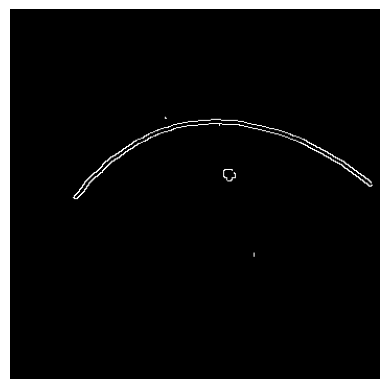

Dilated edges


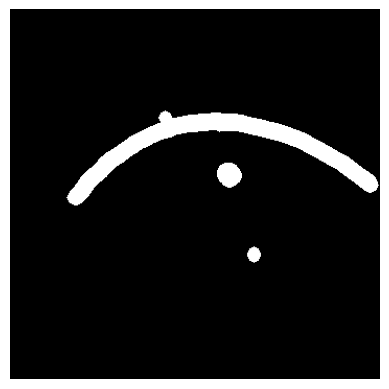

Detected circles


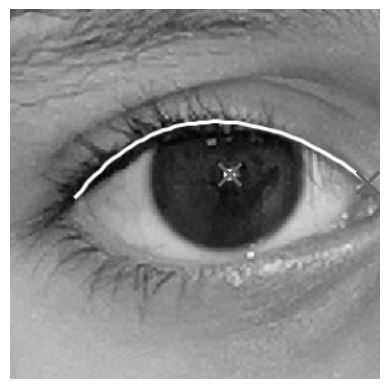

[array([210, 158,  12]), array([342, 166,  10])]

In [386]:
extracted_eyes = get_eyes('sample_3.jpg')

# now the function get center returns many circles for now , one of them is the correct pupil 
# but for some reason , it doesn't work for sample_4 

get_center(extracted_eyes,verbose=True)

#### Old Step by Step (before adjusting the functions parameters above)

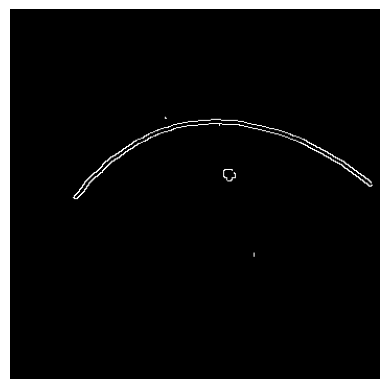

In [366]:
edges = cv2.Canny(extracted_eyes,450,500)
    
plt.imshow(edges,cmap='gray')
plt.axis('off')
plt.show()

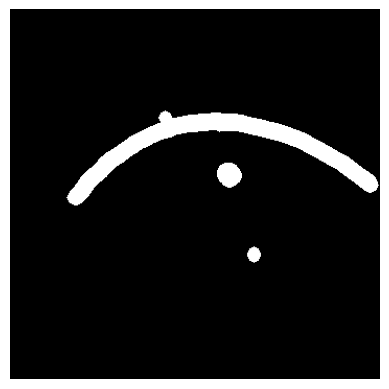

In [367]:
kernel = make_circular_kernel((8,8),3)
edges = cv2.dilate(edges,kernel,iterations=2) 
plt.imshow(edges,cmap='gray')
plt.axis('off')
plt.show()


In [368]:
circles = cv2.HoughCircles(edges, cv2.HOUGH_GRADIENT, 1,80,param1=200,param2=10,minRadius=4,maxRadius=15)
if circles is not None:
    # convert the (x, y) coordinates and radius of the circles to integers
    circles = np.round(circles[0, :]).astype("int")
    circles = sorted(circles,key=lambda x : x[1])
    # loop over the (x, y) coordinates and radius of the circles
    for x, y, _ in circles:
        cv2.drawMarker(extracted_eyes,(x,y),color=(100,255,100),markerType=cv2.MARKER_TILTED_CROSS,thickness=2)

circles

[array([210, 158,  12]), array([342, 166,  10]), array([234, 236,   6])]

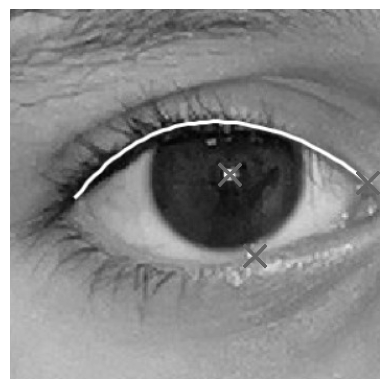

In [369]:
plt.imshow(extracted_eyes,cmap='gray')
plt.axis('off')
plt.show()

**dp:** Inverse ratio of the accumulator resolution to the image resolution. For example, if dp=1 , the accumulator has the same resolution as the input image. If dp=2 , the accumulator has half as big width and height. For HOUGH_GRADIENT_ALT the recommended value is dp=1.5, unless some small very circles need to be detected.

**minDist:** Minimum distance between the centers of the detected circles. If the parameter is too small, multiple neighbor circles may be falsely detected in addition to a true one. If it is too large, some circles may be missed.

**param1** First method-specific parameter. In case of HOUGH_GRADIENT and HOUGH_GRADIENT_ALT, it is the higher threshold of the two passed to the Canny edge detector (the lower one is twice smaller). Note that HOUGH_GRADIENT_ALT uses Scharr algorithm to compute image derivatives, so the threshold value should normally be higher, such as 300 or normally exposed and contrasty images.

**param2:**	Second method-specific parameter. In case of HOUGH_GRADIENT, it is the accumulator threshold for the circle centers at the detection stage. The smaller it is, the more false circles may be detected. Circles, corresponding to the larger accumulator values, will be returned first. In the case of HOUGH_GRADIENT_ALT algorithm, this is the circle "perfectness" measure. The closer it to 1, the better shaped circles algorithm selects. In most cases 0.9 should be fine. If you want get better detection of small circles, you may decrease it to 0.85, 0.8 or even less. But then also try to limit the search range [minRadius, maxRadius] to avoid many false circles